# **CC6204 - Deep Learning**

## **Predicción de riesgo de diabetes en etapas tempranas**

En esta tarea vas a desarrollar un modelo de aprendizaje que sea capaz de  determinar si una persona tiene riesgo de paceder diabetes en un futuro. Los datos han sido coleccionados a través de encuestas a pacientes en el Sylhet Diabetes Hospital en Bangladesh. Los datos han sido curados y verificados por profesionales de la salud, por lo que son confiables para crear un modelo de aprendizaje.

Primero vamos a importar los paquetes necesarios para trabajar en estos datos.

In [1]:
import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import csv
import time
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

FILEPATH = os.getcwd()
SAVE = True

## **Descarga de archivo de datos**
Los datos están disponibles en un archivo CSV que contiene 520 muestras de 17 atributos. Los atributos son:

*   Age: numérico
*   Género: \[Male, Female\]
*   Polyuria
*   Polydipsia
*   sudden weight loss
*   weakness
*   Polyphagia
*   Genital thrush
*   visual blurring
*   Itching
*   Irritability
*   delayed healing
*   partial paresis
*   muscle stiffness
*   Alopecia
*   Obesity
*   Class: \[Positive, Negative\]

Todos los atributos descritos sin valores tienen el conjunto \[Yes, No\].

En la siguiente celda de código, descargamos el archivo y lo leemos con Pandas. Finalmente, visualizamos algunos datos del conjunto.



In [2]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00529/diabetes_data_upload.csv # en colab

# en local, basta descargar el csv del link anterior
dataset_path = 'diabetes_data_upload.csv'

In [3]:
with open('diabetes_data_upload.csv') as inp, open('temp.csv', 'w') as out:
    reader = csv.reader(inp)
    writer = csv.writer(out, delimiter=',')
    #No need to use `insert(), `append()` simply use `+` to concatenate two lists.
    writer.writerow(['ID'] + next(reader))
    #Iterate over enumerate object of reader and pass the starting index as 1.
    writer.writerows([i] + row for i, row in enumerate(reader, 1))

In [4]:
column_names = ['Age','Gender','Polyuria','Polydipsia','sudden weight loss',
                'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring','Itching', 'Irritability', 'delayed healing',
                'partial paresis', 'muscle stiffness', 'Alopecia', 'Obesity', 'class']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=",", skipinitialspace=True, header=1)

dataset = raw_dataset.copy()
dataset.head()

,Age,Gender,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity,class
0,58,Male,No,No,No,Yes,No,No,Yes,No,No,No,Yes,No,Yes,No,Positive
1,41,Male,Yes,No,No,Yes,Yes,No,No,Yes,No,Yes,No,Yes,Yes,No,Positive
2,45,Male,No,No,Yes,Yes,Yes,Yes,No,Yes,No,Yes,No,No,No,No,Positive
3,60,Male,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Positive
4,55,Male,Yes,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,Yes,Positive


# **Pre-procesamiento del conjunto de datos**
El conjunto de datos es variado. El atributo "Age" es el único atributo numérico. Todos los demás atributos son nominales. Para procesar los datos nominales en una red neuronal, es mejor convertirlos a una representación numérica. En el siguiente ejemplo transformamos el atributo "Gender" con valores nominales "Female" y "Male" a valores 1.0 y 0.0, respectivamente.

Del mismo modo, cambiamos los valores nominales de todos los atributos a valores 0.0 y 1.0.

In [5]:
gender = dataset.pop('Gender')
dataset['Gender'] = (gender == 'Female')*1.0

column_class = dataset.pop('class')
dataset['class'] = (column_class=='Positive')*1.0

for column in column_names:
    if column not in ['Gender', 'class', 'Age']:
        column_class = dataset.pop(column)
        dataset[column] = (column_class=='Yes')*1.0

# Prueba mostrando parte de la data para ver si tu conversión se hizo correctamente
dataset.tail()

,Age,Gender,class,Polyuria,Polydipsia,sudden weight loss,weakness,Polyphagia,Genital thrush,visual blurring,Itching,Irritability,delayed healing,partial paresis,muscle stiffness,Alopecia,Obesity
514,39,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
515,48,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0
516,58,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
517,32,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0
518,42,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Ahora normalizamos el atributo "Age" y dividimos la data en conjunto de entrenamiento y conjunto de test. Esta división es siempre necesaria para poder probar si tu modelo de aprendizaje ha aprendido a generalizar con datos que no pertenecen al conjunto de entrenamiento.

In [6]:
max_age = dataset["Age"].max()
dataset["Age"] = dataset["Age"] / max_age

#80% de datos para train y 20% de datos para test
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

train_labels = train_dataset.pop('class')
test_labels = test_dataset.pop('class')

In [7]:
#Convertimos todo a arrays Numpy
X_train = train_dataset.to_numpy()
X_test = test_dataset.to_numpy()

Y_train = train_labels.to_numpy()
Y_test = test_labels.to_numpy()

Y_train = Y_train[:,None]
Y_test = Y_test[:,None]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(415, 16)
(415, 1)
(104, 16)
(104, 1)


In [8]:
# Pasamos a tensores de Pytorch
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

Y_train = torch.tensor(Y_train, dtype=torch.float32)
Y_test = torch.tensor(Y_test, dtype=torch.float32)

# Juntamos la data para usarla en el DataLoader
train_data = list(zip(X_train, Y_train))
test_data = list(zip(X_test, Y_test))

# **Parte 1**
Diseña y entrena un perceptrón multicapa con la data de arriba. Intenta que tu modelo alcance el mayor accuracy de test posible (ojalá por encima del 93%). Para este primer experimento puedes usar la implementación de MLP vista en clase (basada en Numpy) ó puedes usar algún framework como Tensorflow o Pytorch si es que deseas. Hay que tener en cuenta algunas consideraciones para este primer experimento:



*   Usar gradiente descendiente estocástico con un tamaño de mini-batch de 20.
*   Usar learning rate de 0.01.
*  Los mini-batches NO se generan de manera aleatoria.

Graficar la función de loss con respecto a las épocas.

In [9]:
# Utilizaremos una red con dos capas ocultas

# Número de neuronas por capa
NLAYERS_1 = 30
NLAYERS_2 = 15

# Definimos la clase MLP
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):        
        super().__init__()
        
        self.fc1 = nn.Linear(input_dim, NLAYERS_1)
        self.fc2 = nn.Linear(NLAYERS_1, NLAYERS_2)
        self.fc3 = nn.Linear(NLAYERS_2, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        h_1 = F.relu(self.fc1(x))
        h_2 = F.relu(self.fc2(h_1))
        y_pred = self.fc3(h_2)

        return torch.sigmoid(y_pred)

In [10]:
def calculate_accuracy(y_pred, y):
    class_pred = (y_pred > 0.5).float()
    correct = class_pred.eq(y.view_as(class_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred = model(x)
        
        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y) 

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():
        
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [11]:
# Generamos los batches
BATCH_SIZE = 20

train_iterator = data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [12]:
# Inicializamos el modelo
INPUT_DIM = 16
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM)

LEARNING_RATE = 0.01

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

criterion = nn.BCELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

# Entrenamos
EPOCHS = 200

train_loss_list = []
train_accuracy_list = []

test_loss_list = []
test_accuracy_list = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
    
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_acc)
    
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_acc)

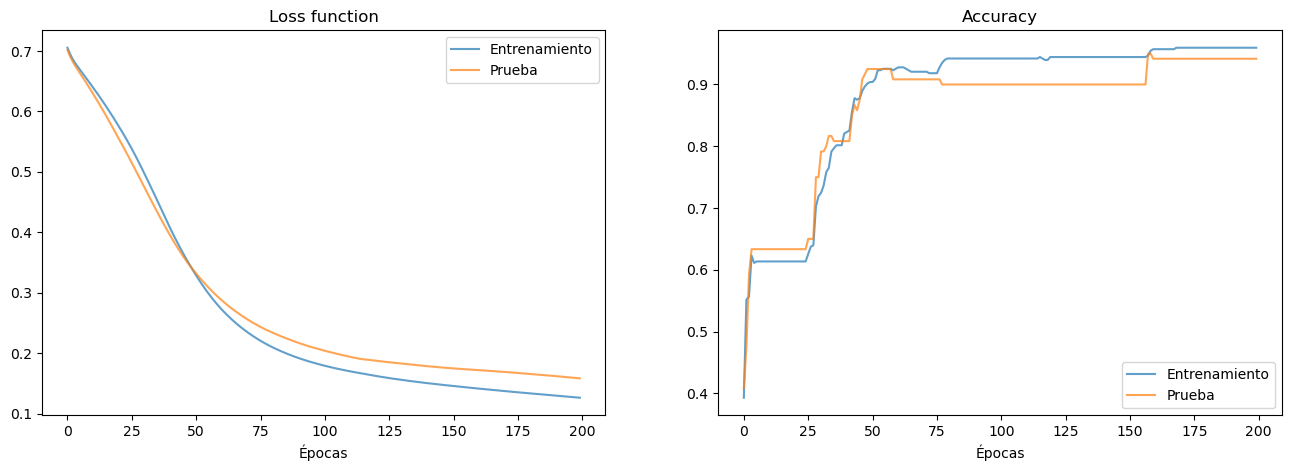

In [13]:
# Graficamos
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

titles = ['Loss function', 'Accuracy']
train_plots = [train_loss_list, train_accuracy_list]
test_plots = [test_loss_list, test_accuracy_list]

for i, ax in enumerate(axs.flatten()):
    ax.set_title(titles[i])
    ax.set_xlabel('Épocas')
    ax.plot(train_plots[i], label='Entrenamiento', alpha=0.7)
    ax.plot(test_plots[i], label='Prueba', alpha=0.7)
    ax.legend()
    
if SAVE:
    plt.savefig(f'{FILEPATH}\\Imágenes\\part_1.pdf', bbox_inches='tight')

plt.show()

In [14]:
# Predecimos en conjunto de test
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.158 | Test Acc: 94.17%


# **Parte 2**
Intenta cambiar el tamaño de los mini-batches. Como casos extremos usa m=1 (mini-batches de tamaño 1) y m=n(1 solo mini-batch con todos los datos). Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [15]:
# Generamos los batches de distintos tamaños
BATCH_SIZES = [1, 20, len(train_data)//2, len(train_data)]

train_iterator = [data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE) for BATCH_SIZE in BATCH_SIZES]
test_iterator = [data.DataLoader(test_data, batch_size=BATCH_SIZE) for BATCH_SIZE in BATCH_SIZES]

In [16]:
# Entrenamos para cada BATCH_SIZE
EPOCHS = 200

models = []

train_loss_lists = []
train_accuracy_lists = []

test_loss_lists = []
test_accuracy_lists = []

for i, BATCH_SIZE in enumerate(BATCH_SIZES):
    # Inicializamos el modelo
    INPUT_DIM = 16
    OUTPUT_DIM = 1

    model = MLP(INPUT_DIM, OUTPUT_DIM)

    LEARNING_RATE = 0.01

    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    criterion = nn.BCELoss()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    criterion = criterion.to(device)
    
    # Entrenamos
    train_loss_list = []
    train_accuracy_list = []
    
    test_loss_list = []
    test_accuracy_list = []
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_iterator[i], optimizer, criterion, device)
        test_loss, test_acc = evaluate(model, test_iterator[i], criterion, device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_acc)

        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_acc)
        
    models.append(model)
    
    train_loss_lists.append(train_loss_list)
    train_accuracy_lists.append(train_accuracy_list) 
    
    test_loss_lists.append(test_loss_list)
    test_accuracy_lists.append(test_accuracy_list) 

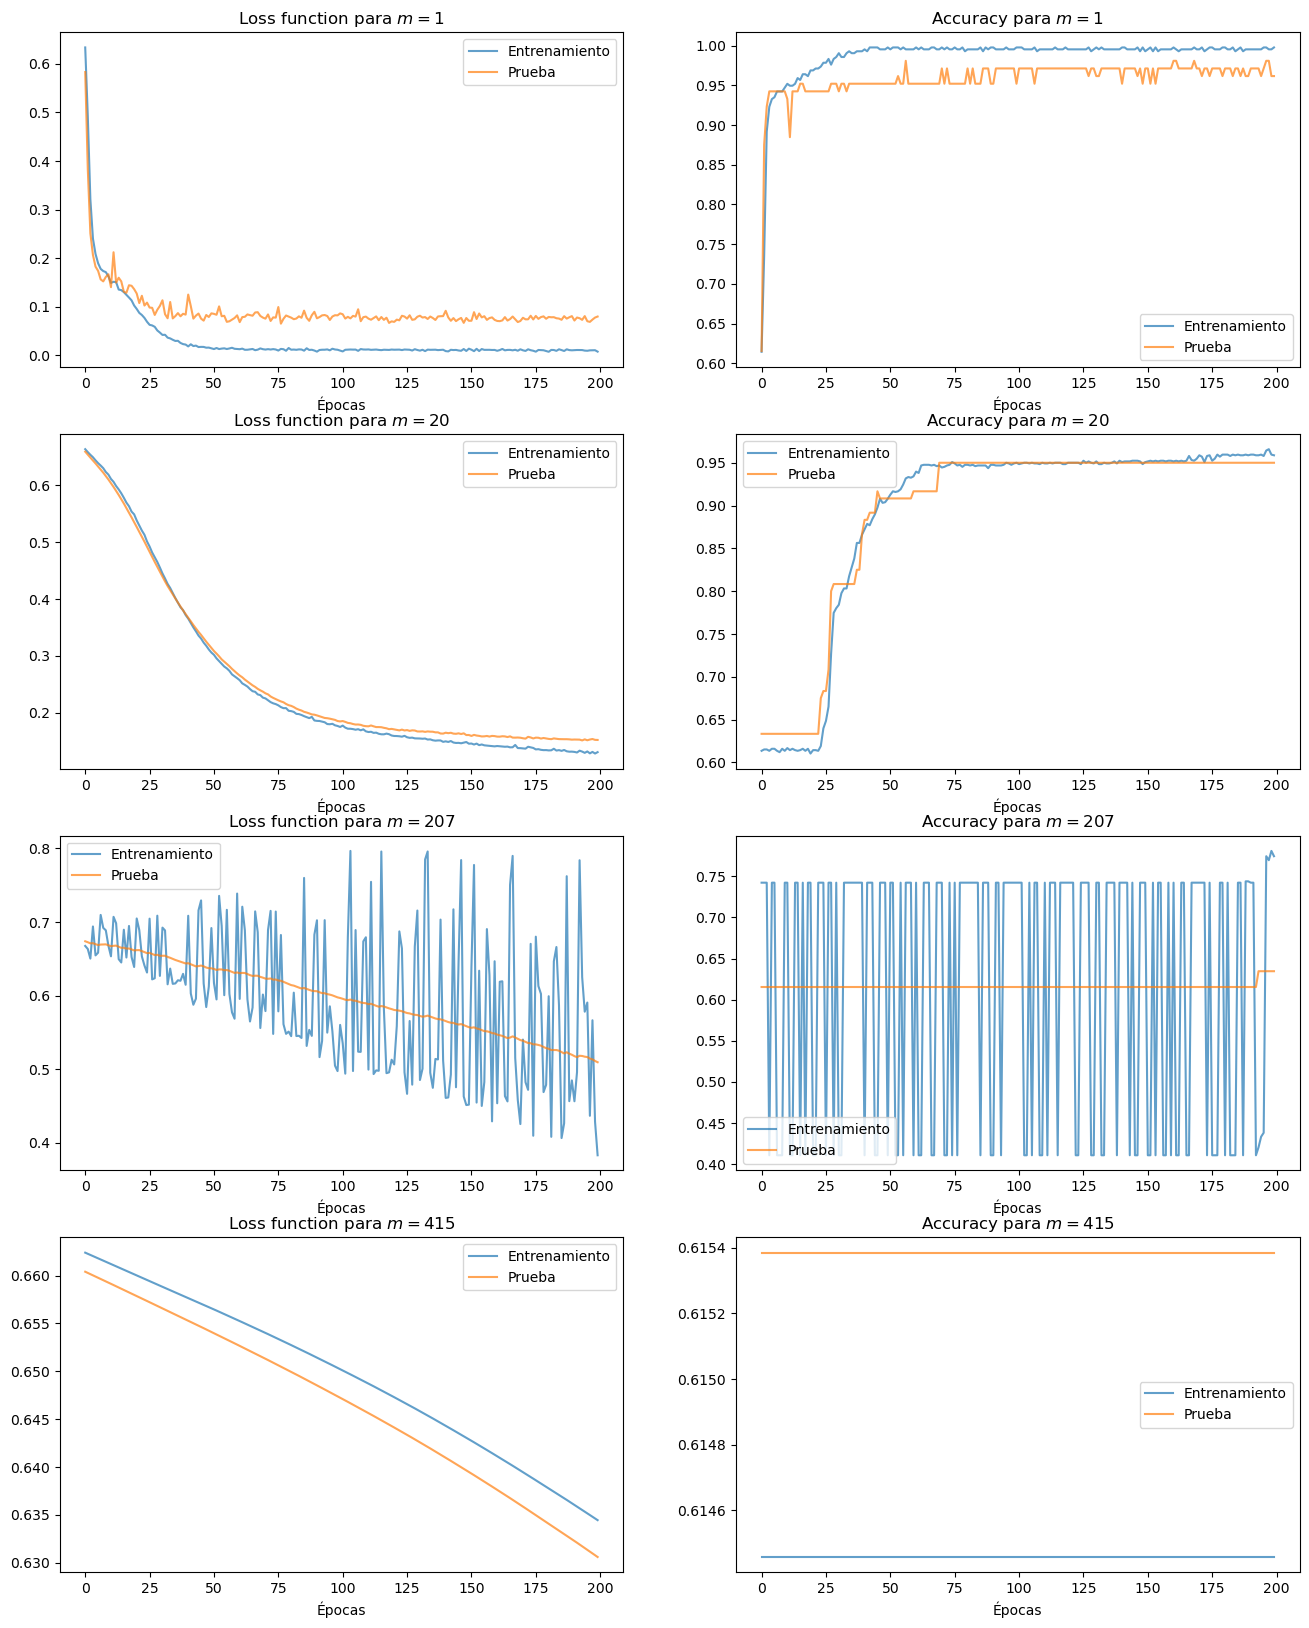

In [17]:
# Graficamos
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(16, 20))

titles = ['Loss function', 'Accuracy']
train_plots = [train_loss_lists, train_accuracy_lists]
test_plots = [test_loss_lists, test_accuracy_lists]
colors = ['green', 'blue', 'yellow', 'red']

for k, ax in enumerate(axs.flatten()):
    i, j = k // 2, k % 2
    ax.set_title(rf'{titles[j]} para $m=${BATCH_SIZES[i]}')
    ax.set_xlabel('Épocas')
    #for j, BATCH_SIZE in enumerate(BATCH_SIZES):
    ax.plot(train_plots[j][i], label=rf'Entrenamiento', alpha=0.7)
    ax.plot(test_plots[j][i], label=rf'Prueba', alpha=0.7)
    ax.legend()
    
if SAVE:
    plt.savefig(f'{FILEPATH}\\Imágenes\\part_2.pdf', bbox_inches='tight')

plt.show()

In [18]:
# Predecimos en conjunto de test
for i, BATCH_SIZE in enumerate(BATCH_SIZES): 
    test_loss, test_acc = evaluate(models[i], test_iterator[i], criterion, device)
    print(f'Test Loss para m={BATCH_SIZE}: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss para m=1: 0.080 | Test Acc: 96.15%
Test Loss para m=20: 0.152 | Test Acc: 95.00%
Test Loss para m=207: 0.509 | Test Acc: 63.46%
Test Loss para m=415: 0.631 | Test Acc: 61.54%


**Justificación.**

Podemos ver que para batches de tamaño $1$ (lo menor posible), el modelo logra el mejor accuracy en el conjunto de entrenamiento, sin embargo, esto se produce porque el modelo sobreajusta. Esto lo podemos comprobar al ver el accuracy en el conjunto de prueba que empieza a disminuir luego de pocas épocas.  Por otro lado, tomar un batch de tamaño $415$ (lo mayor posible), el modelo se queda estancado en un accuracy bajo y la función de loss disminuye muy lentamente, esto se debe a que estamos utilizando todos los datos para calcular el gradiente en cada paso.

Para un tamaño de batch $m=20$ (como en la parte 1) vemos que el modelo aprende la data de entrenamiento y generaliza bien en el conjunto de prueba, por lo que se obtiene un desempeño aceptable para este valor. Por último, para un tamaño de batch $m=207$ (mitad del dataset) vemos que la loss en el conjunto de entrenamiento disminuye pero de manera ruidosa, además, el accuracy en el conjunto de prueba se estanca en $65,38\%$, lo que quiere decir que el modelo no está generalizando.

Como conclusión, vemos que el tamaño del batch es un hiperparámetro importante a considerar en el desempeño de nuestro modelo. Vemos que a medida que consideramos batch de tamaño más pequeño, el modelo logra un mayor rendimiento, sin embargo, las contras de esto, es que el entrenamiento tomará más tiempo, ya que procesamos un dato para realizar un paso del descenso gradiente. Además de que podemos caer fácilmente en el sobreajuste del modelo.

# **Parte 3**
Intenta cambiar el learning rate. Como casos extremos usa lr = 0.5 y lr = 0.000001. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [19]:
# Generamos los batches
BATCH_SIZE = 20

train_iterator = data.DataLoader(train_data, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [20]:
# Entrenamos para cada BATCH_SIZE
EPOCHS = 200
LEARNING_RATES = [0.01, 0.5, 0.000001]

models = []

train_loss_lists = []
train_accuracy_lists = []

test_loss_lists = []
test_accuracy_lists = []

for i, LEARNING_RATE in enumerate(LEARNING_RATES):
    # Inicializamos el modelo
    INPUT_DIM = 16
    OUTPUT_DIM = 1

    model = MLP(INPUT_DIM, OUTPUT_DIM)

    optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

    criterion = nn.BCELoss()

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = model.to(device)
    criterion = criterion.to(device)
    
    # Entrenamos
    train_loss_list = []
    train_accuracy_list = []
    
    test_loss_list = []
    test_accuracy_list = []
    
    for epoch in range(EPOCHS):
        train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
        test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_acc)

        test_loss_list.append(test_loss)
        test_accuracy_list.append(test_acc)
        
    models.append(model)
    
    train_loss_lists.append(train_loss_list)
    train_accuracy_lists.append(train_accuracy_list) 
    
    test_loss_lists.append(test_loss_list)
    test_accuracy_lists.append(test_accuracy_list) 

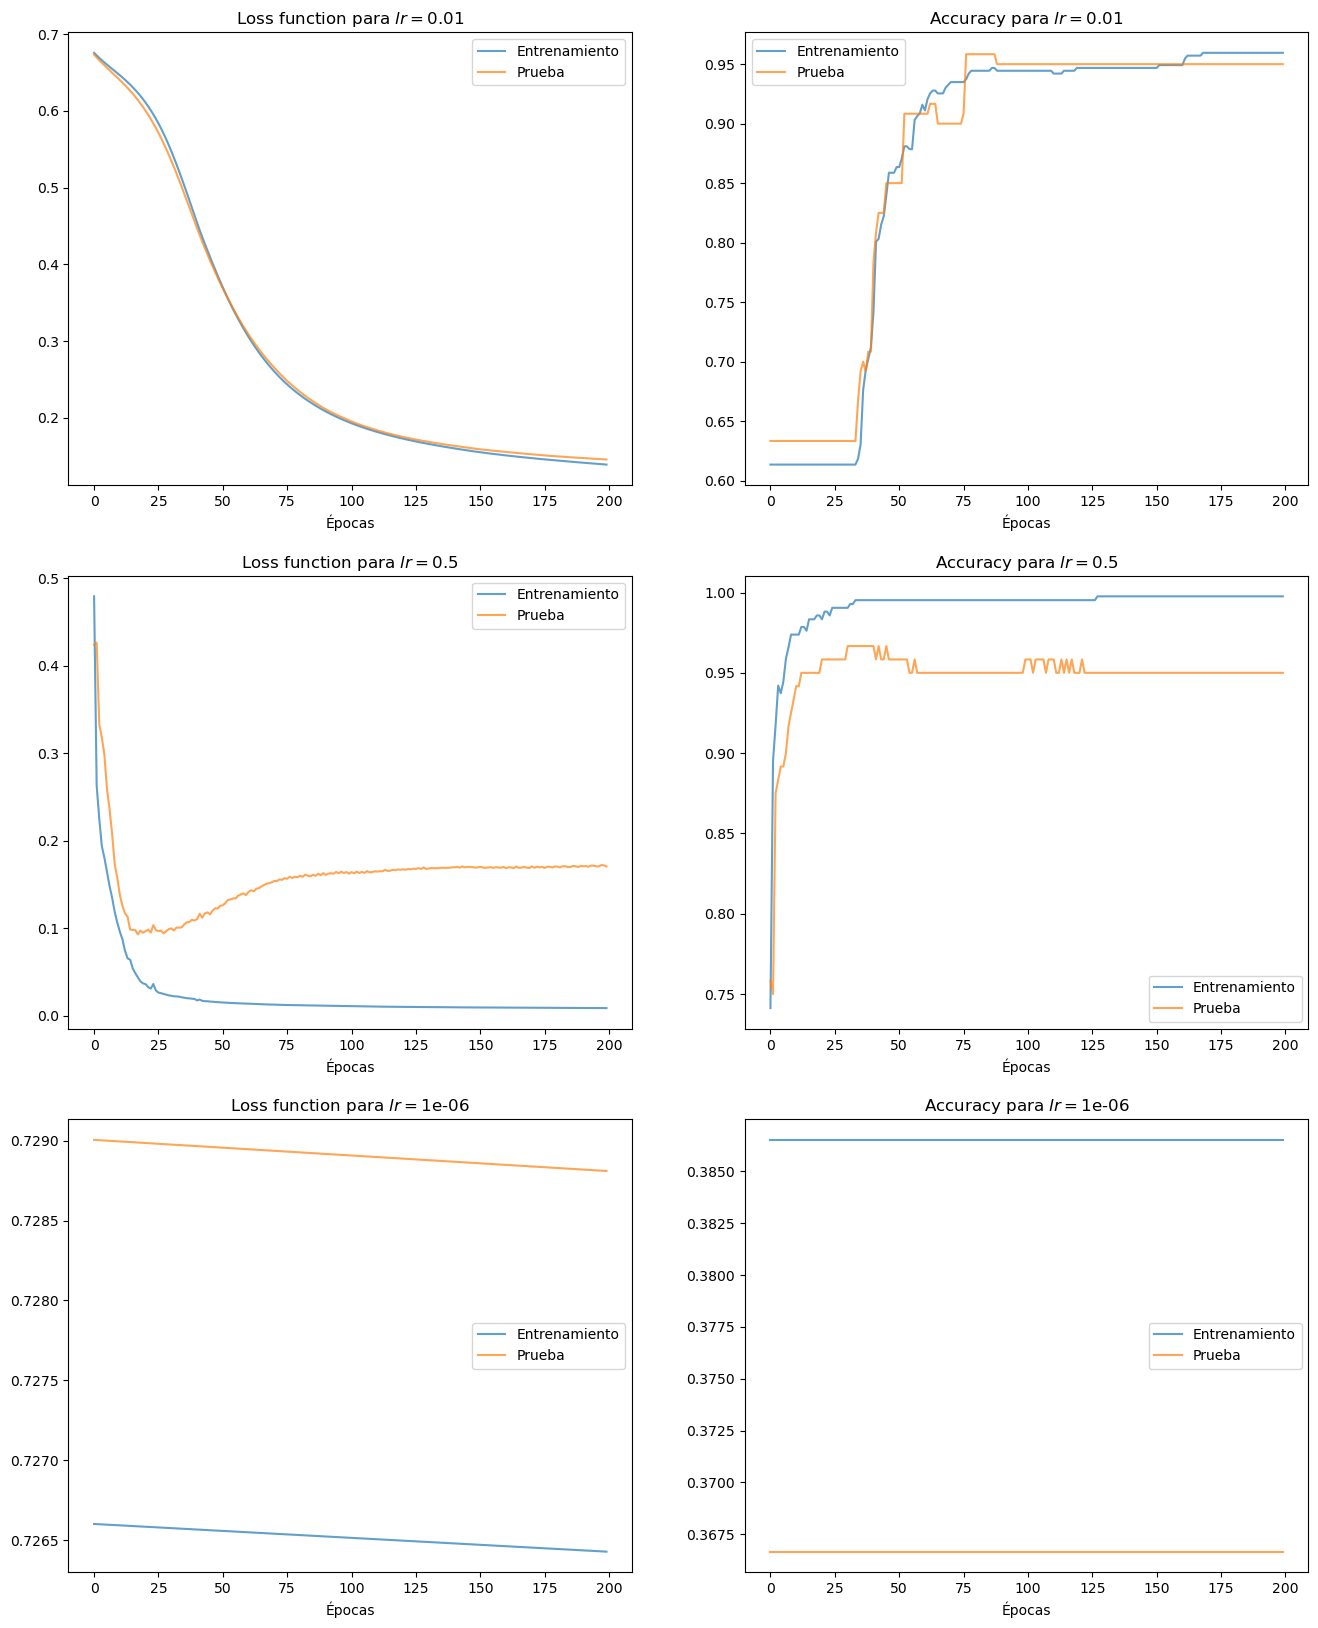

In [21]:
# Graficamos
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(16, 20))

titles = ['Loss function', 'Accuracy']
train_plots = [train_loss_lists, train_accuracy_lists]
test_plots = [test_loss_lists, test_accuracy_lists]
colors = ['green', 'blue', 'yellow', 'red']

for k, ax in enumerate(axs.flatten()):
    i, j = k // 2, k % 2
    ax.set_title(rf'{titles[j]} para $lr=${LEARNING_RATES[i]}')
    ax.set_xlabel('Épocas')
    ax.plot(train_plots[j][i], label=rf'Entrenamiento', alpha=0.7)
    ax.plot(test_plots[j][i], label=rf'Prueba', alpha=0.7)
    ax.legend()
    
if SAVE:
    plt.savefig(f'{FILEPATH}\\Imágenes\\part_3.pdf', bbox_inches='tight')

plt.show()

In [22]:
# Predecimos en conjunto de test
for i, LEARNING_RATE in enumerate(LEARNING_RATES): 
    test_loss, test_acc = evaluate(models[i], test_iterator, criterion, device)
    print(f'Test Loss para lr={LEARNING_RATE}: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss para lr=0.01: 0.145 | Test Acc: 95.00%
Test Loss para lr=0.5: 0.170 | Test Acc: 95.00%
Test Loss para lr=1e-06: 0.729 | Test Acc: 36.67%


**Justificación.**

En este caso podemos ver que un learning rate bajísimo como $lr=10^{-6}$ hace que el modelo aprenda de manera muy lenta como vemos en los gráficos, la loss tanto en el conjunto de entrenamiento como en el de prueba disminuye pero lentamente. Por otro lado, al tomar $lr=0.5$ vemos que el modelo aprende rápido pero se sobreajusta a las pocas épocas, esto pues los pasos que damos en la dirección del gradiente (dirección de máximo descenso) son más grandes, lo que sugiere que es un valor muy alto. Sin embargo, vemos que el accuracy en el conjunto de prueba es igual que el modelo con $lr=0.01$ (de la parte 1). Con esto, podemos concluir que el learning rate es un hiperpárametro que afecta el desempeño del modelo, y en este caso tomar un valor cercano a $lr=0.5$ sería adecuado si consideramos una menor cantidad de épocas.

# **Parte 4**
Implementar el algoritmo de gradiente descendente estocástico de manera que los mini-batches se generen de manera aleatoria antes de cada época. Qué resultados obtienes? Discute los resultados. (Hay que explicar el fenómeno observado, dando su opinión de porqué sucede).

Graficar la función de loss con respecto a las épocas y comparar con la función de loss de la Parte 1.

In [23]:
# Generamos los batches
BATCH_SIZE = 20

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [24]:
# Inicializamos el modelo
INPUT_DIM = 16
OUTPUT_DIM = 1

model = MLP(INPUT_DIM, OUTPUT_DIM)

LEARNING_RATE = 0.01

optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

criterion = nn.BCELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

# Entrenamos
EPOCHS = 200

train_loss_list = []
train_accuracy_list = []

test_loss_list = []
test_accuracy_list = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
    
    train_loss_list.append(train_loss)
    train_accuracy_list.append(train_acc)
    
    test_loss_list.append(test_loss)
    test_accuracy_list.append(test_acc)

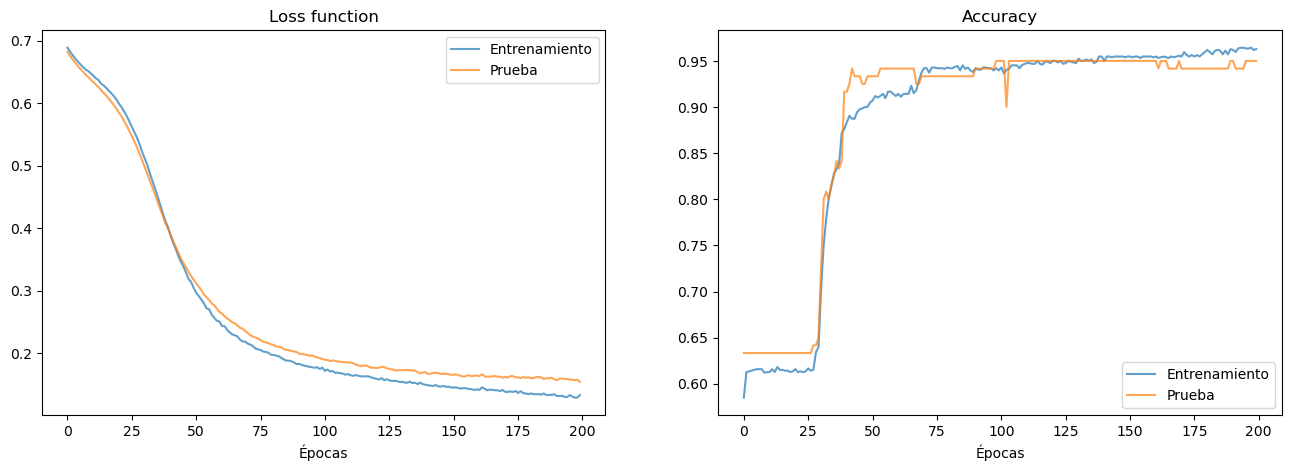

In [25]:
# Graficamos
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

titles = ['Loss function', 'Accuracy']
train_plots = [train_loss_list, train_accuracy_list]
test_plots = [test_loss_list, test_accuracy_list]

for i, ax in enumerate(axs.flatten()):
    ax.set_title(titles[i])
    ax.set_xlabel('Épocas')
    ax.plot(train_plots[i], label='Entrenamiento', alpha=0.7)
    ax.plot(test_plots[i], label='Prueba', alpha=0.7)
    ax.legend()
    
if SAVE:
    plt.savefig(f'{FILEPATH}\\Imágenes\\part_4.pdf', bbox_inches='tight')

plt.show()

In [26]:
# Predecimos en conjunto de test
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.154 | Test Acc: 95.00%


**Justificación.**

En este caso no se observan diferencias significativas entre el desempeño entre el modelo de la parte 1 (con los batches generados en orden) con este modelo que genera los batches en un orden aleatorio. Lo que podemos notar es que la loss y el accuracy presentan un mayor ruido en este modelo, sin embargo, ambos modelos obtenidos son igual de buenos. En conclusión, la forma de generar los batches (en orden o aleatorio) no influye de manera importante en el desempeño del modelo.